In [1]:
# %matplotlib inline
# %load_ext autoreload
# %autoreload 2

from __future__ import print_function

import os
import sys
import matplotlib.pyplot as plt

from keras.applications.imagenet_utils import preprocess_input
from keras.models import load_model
from keras.datasets import mnist

sys.path.append('..')
from utils import RotNetDataGenerator, angle_error, binarize_images, get_deformations

import numpy as np

import tensorflow as tf
import cv2
import math
from mpl_toolkits.axes_grid1 import AxesGrid
from math import ceil

Using TensorFlow backend.


## Load data

In [2]:
# (X_train, y_train), (X_test, y_test) = mnist.load_data()

data = np.load('train.p')

X_train = np.sum(data['features'], axis=3) / 3   # RGB->grayscale
y_train = data['labels']

data = np.load('test.p')
X_test = np.sum(data['features'], axis=3) / 3   # RGB->grayscale
y_test = data['labels']

model_name = 'rotnet_mnist'

## Load model

In [3]:
model_location = os.path.join('..', 'train', 'models', 'rotnet_mnist.hdf5')
model = load_model(model_location, custom_objects={'angle_error': angle_error})

## Evaluate model

In [4]:
batch_size = 128
out = model.evaluate_generator(
    RotNetDataGenerator(
        X_test,
        batch_size=batch_size,
        preprocess_func=binarize_images,
        shuffle=True,
        color_mode='grayscale'
    ), 
    steps=len(y_test) / batch_size
)

print('Test loss:', out[0])
print('Test angle error:', out[1])

Test loss: 1.0720293402577428
Test angle error: 7.450910531011537


## Display examples

(5, 32, 32)


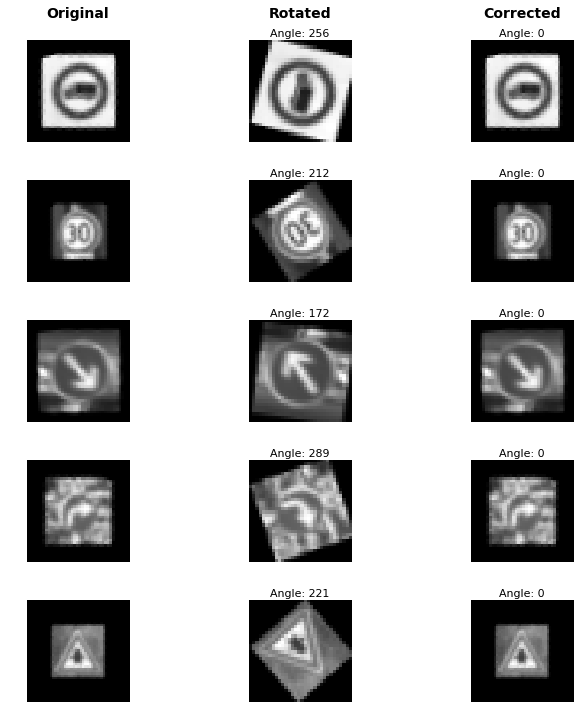

In [5]:
num_images = 5

thetas, X_test_rotated = get_deformations(
    model, 
    X_test,
    num_images=num_images,
    preprocess_func=binarize_images,
    display=True
)
print(X_test_rotated.shape)

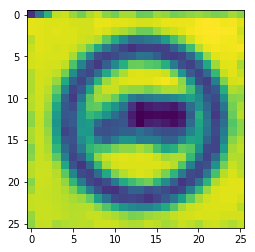

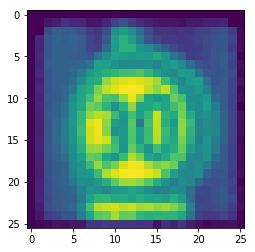

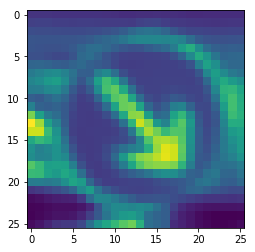

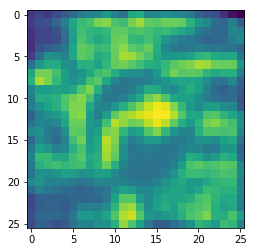

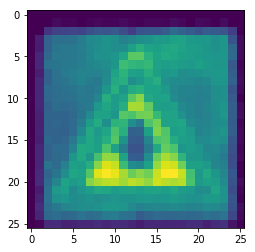

In [6]:
idx = 0
stn_output = np.array([])
for angle in thetas:
    img = X_test_rotated[idx]

    rows,cols = img.shape

    M = cv2.getRotationMatrix2D((cols/2,rows/2),-angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))[3:-3,3:-3]
#     print(M)
    plt.imshow(dst)
    plt.pause(0.5)
    
    if stn_output.shape[0] == 0:
        stn_output = dst
    else:
        stn_output = np.vstack((stn_output,dst))
    
    idx += 1